## Generate the breast and FGT masks for the ispy data 

In [6]:
#first let us import the necessary modules

import matplotlib.pyplot as plt
import pydicom
from preprocessing import *
from ispy_utils import *
import numpy as np

In [7]:
#setting file paths

#precontrast image path
file_pre ='data/manifest-1722210581008/ISPY2/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/500.000000-ISPY2 AX VIBRANT-SERIES-52523'

#postcontrast image path
file_post = 'data/manifest-1722210581008/ISPY2/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/501.000000-ISPY2 Ph1AX VIBRANT-SERIES-03969'



In [14]:
dicom_data = pydicom.dcmread(file_pre + "/1-042.dcm")
# Extracting pixel spacing (x, y dimensions)
pixel_spacing = dicom_data.PixelSpacing  # This is usually a list: [row_spacing, column_spacing]
print(pixel_spacing)

slice_thickness = getattr(dicom_data, 'SliceThickness', None)  # It's optional in some cases
print(slice_thickness)

# Combine all dimensions
voxel_dimensions = [pixel_spacing[0], pixel_spacing[1], slice_thickness]

print(f"Voxel Dimensions (in mm): {voxel_dimensions}")

[0.6641, 0.6641]
2
Voxel Dimensions (in mm): ['0.6641', '0.6641', '2.0']


(512, 512, 106)


(-0.5, 511.5, 511.5, -0.5)

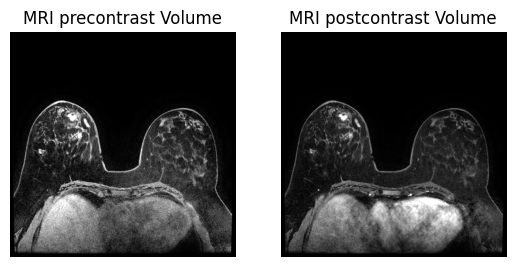

In [4]:
#apply function from ispymri.py 
image_array_pre, dcm_data_pre = read_ispy_mri(file_pre)
image_array_pre = zscore_image(normalize_image(image_array_pre))
# saving image - will be used as an input to prediction code
np.save('./input_pre/output.npy', image_array_pre)
print(image_array_pre.shape)  #optional

image_array_post, dcm_data_post = read_ispy_mri(file_post)
image_array_post = zscore_image(normalize_image(image_array_post))
np.save('./input_post/output.npy', image_array_post)


#plotting both the images

plt.subplot(1,2,1)
plt.title('MRI precontrast Volume')
plt.imshow(image_array_pre[:,:,41], cmap = 'gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('MRI postcontrast Volume')
plt.imshow(image_array_post[:,:,41], cmap='gray')
plt.axis('off')


#### Below is the line of code that generates a breast mask
 
```python predict.py --target-tissue breast --image ./input_pre --save-masks-dir ./mask --model-save-path ./trained_models/breast_model.pth```


(512, 512, 106)


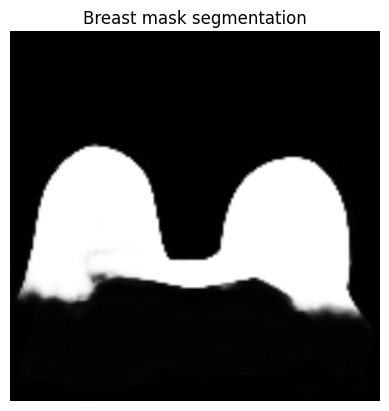

In [5]:
breast_mask_seg = np.load('./mask/output.npy')
print(breast_mask_seg.shape)

#plotting the mask
plt.imshow(breast_mask_seg[:, :, 42], cmap = 'gray')
plt.title('Breast mask segmentation')
plt.axis('off')
plt.show()

Splitting of mask in half

Shape of original Breast Mask Segmentation data: (512, 512, 106)


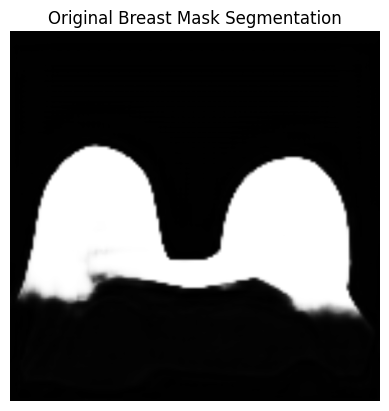

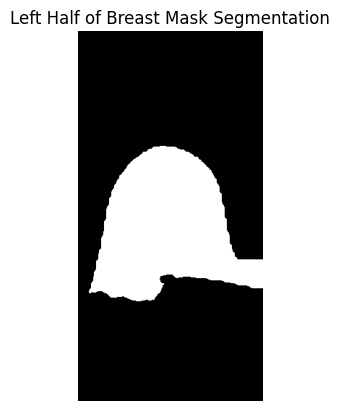

Left half:
 [[[0.02444  0.01753  0.01537  ... 0.01556  0.01773  0.02388 ]
  [0.02444  0.01753  0.01537  ... 0.01556  0.01773  0.02388 ]
  [0.02298  0.01668  0.01474  ... 0.01499  0.01701  0.02249 ]
  ...
  [0.01529  0.01205  0.011375 ... 0.01114  0.01181  0.01406 ]
  [0.0153   0.01205  0.011375 ... 0.01116  0.01183  0.01407 ]
  [0.01532  0.01208  0.01139  ... 0.01112  0.01179  0.01405 ]]

 [[0.02444  0.01753  0.01537  ... 0.01556  0.01773  0.02388 ]
  [0.02444  0.01753  0.01537  ... 0.01556  0.01773  0.02388 ]
  [0.02298  0.01668  0.01474  ... 0.01499  0.01701  0.02249 ]
  ...
  [0.01529  0.01205  0.011375 ... 0.01114  0.01181  0.01406 ]
  [0.0153   0.01205  0.011375 ... 0.01116  0.01183  0.01407 ]
  [0.01532  0.01208  0.01139  ... 0.01112  0.01179  0.01405 ]]

 [[0.02315  0.01678  0.01473  ... 0.01494  0.01698  0.0226  ]
  [0.02315  0.01678  0.01473  ... 0.01494  0.01698  0.0226  ]
  [0.02177  0.01607  0.01424  ... 0.01451  0.01642  0.02135 ]
  ...
  [0.014496 0.01197  0.01144  ... 0.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os

breast_mask_seg = np.load('./mask/output.npy')
print("Shape of original Breast Mask Segmentation data:", breast_mask_seg.shape)

plt.imshow(breast_mask_seg[:,:,42], cmap='gray')
plt.title('Original Breast Mask Segmentation')
plt.axis('off')
plt.show()

mid_index = breast_mask_seg.shape[1] // 2

left_half = breast_mask_seg[:, :mid_index, :]

plt.imshow(left_half[:,:,42]>0.5, cmap = 'gray')
plt.title('Left Half of Breast Mask Segmentation')
plt.axis('off')
plt.show()

# plt.imshow(left_half[:,:,42], cmap = 'gray')
# plt.title('Left Half of Breast Mask Segmentation')
# plt.axis('off')
# plt.show()

# plt.imshow(left_half[:,:,38] == 1, cmap = 'gray')
# plt.title('Left Half of Breast Mask Segmentation')
# plt.axis('off')
# plt.show()





print("Left half:\n", left_half)

np.save('./mask/mask_left.npy', left_half)



The line of code below runs fgt prediction for pre contrast and post contrast respectively

### pre contrast
python predict.py --target-tissue dv --image ./input_pre --input-mask ./mask --save-masks-dir ./fgt_pre --model-save-path ./trained_models/dv_model.pth

### post contrast
python predict.py --target-tissue dv --image ./input_post --input-mask ./mask --save-masks-dir ./fgt_post --model-save-path ./trained_models/dv_model.pth

(3, 512, 512, 106)


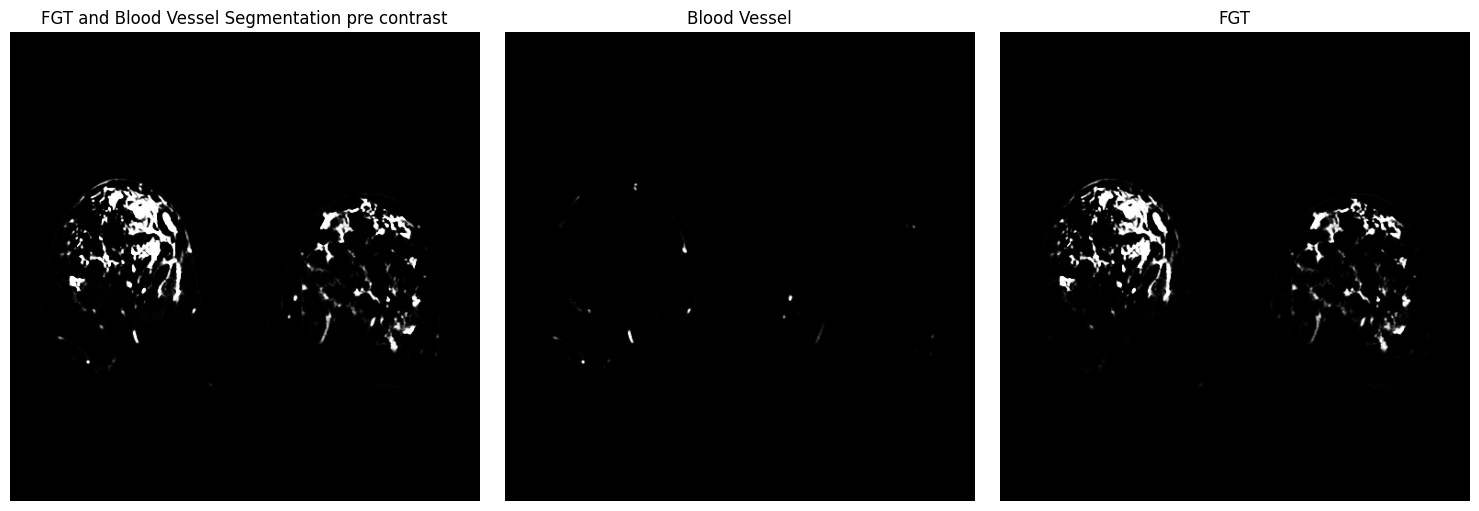

In [6]:
#shape of fgt
import numpy as np
import matplotlib.pyplot as plt

fgt_data_pre = np.load('./fgt_pre/output.npy')
print(fgt_data_pre.shape)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#plotting the data
axes[0].imshow(fgt_data_pre[0, :, :, 41], cmap = 'Greys')
axes[0].set_title('FGT and Blood Vessel Segmentation pre contrast')
axes[0].axis('off')
#plt.show()

axes[1].imshow(fgt_data_pre[1, :, :, 41], cmap = 'gray')
axes[1].set_title('Blood Vessel')
axes[1].axis('off')
#plt.show()

axes[2].imshow(fgt_data_pre[2, :, :, 41], cmap = 'gray')
axes[2].set_title('FGT')
axes[2].axis('off')
#plt.show()
# Show the figure
plt.tight_layout()
plt.show()

Splitting left half of the breast and right half of the breast

Shape of FGT data: (3, 512, 512, 106)
Shape of slice 42: (512, 512, 106)


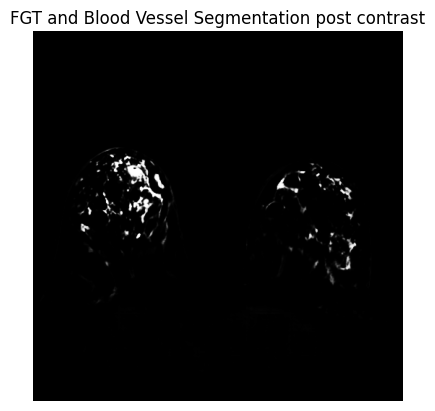

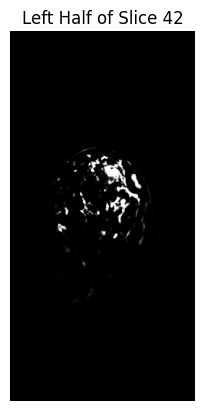

Left half:
 [[[3.7098e-04 3.9148e-04 5.5456e-04 ... 7.5197e-04 6.2561e-04 6.0987e-04]
  [3.5071e-04 4.3702e-04 5.9843e-04 ... 7.4816e-04 7.1430e-04 5.9223e-04]
  [5.9223e-04 7.5483e-04 7.8297e-04 ... 1.1358e-03 9.4938e-04 8.3542e-04]
  ...
  [1.0719e-03 8.9693e-04 1.0223e-03 ... 1.5984e-03 1.6012e-03 1.5860e-03]
  [1.0567e-03 8.6784e-04 9.8419e-04 ... 1.5907e-03 1.6117e-03 1.5831e-03]
  [1.0271e-03 8.2302e-04 9.3889e-04 ... 1.5831e-03 1.5993e-03 1.5831e-03]]

 [[3.4714e-04 2.9087e-04 5.9748e-04 ... 8.7500e-04 7.2622e-04 5.4836e-04]
  [3.7503e-04 2.9254e-04 5.5170e-04 ... 6.2275e-04 5.8460e-04 3.5644e-04]
  [6.2704e-04 6.0892e-04 8.1110e-04 ... 8.7833e-04 7.5245e-04 6.0940e-04]
  ...
  [1.3943e-03 6.5851e-04 5.6744e-04 ... 4.0197e-04 4.5943e-04 8.8692e-04]
  [1.3657e-03 6.4182e-04 5.5695e-04 ... 3.9983e-04 4.6349e-04 8.8882e-04]
  [1.3294e-03 6.1512e-04 5.4932e-04 ... 3.9864e-04 4.6754e-04 8.8692e-04]]

 [[2.8181e-04 2.3818e-04 5.7125e-04 ... 6.6566e-04 5.7650e-04 4.7588e-04]
  [3.6573e

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fgt_data_post = np.load('./fgt_post/output.npy')
print("Shape of FGT data:", fgt_data_post.shape)

slice_fgt = fgt_data_post[2, :, :, :]
print("Shape of slice 42:", slice_fgt.shape)

plt.imshow(slice_fgt[:,:,42], cmap='gray')
plt.title('FGT and Blood Vessel Segmentation post contrast')
plt.axis('off')
plt.show()

mid_index = slice_fgt.shape[1] // 2

left_half = slice_fgt[:, :mid_index, :]

plt.imshow(left_half[:,:,42], cmap='gray')
plt.title('Left Half of Slice 42')
plt.axis('off')
plt.show()

print("Left half:\n", left_half)

np.save('./half_breast/left_half_post.npy', left_half)



# total breast volume (prolly an overestimate)
# non fat tissue volume in cc post contrast
# look at pre contrast for comparison
# show the images associated with it
# only care about post contrast and calculate percent signal intensity
# display the images/ histogram
# overlay the signal intensity over the original image (original MRI)

Shape of FGT data: (3, 512, 512, 106)
Shape of slice 42: (512, 512, 106)


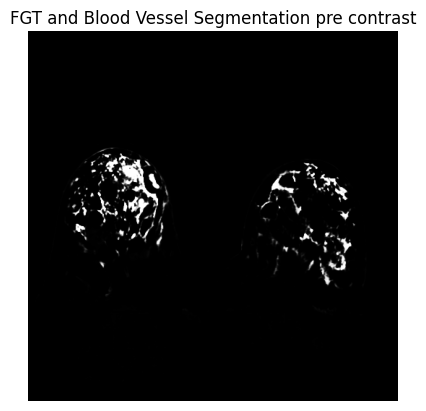

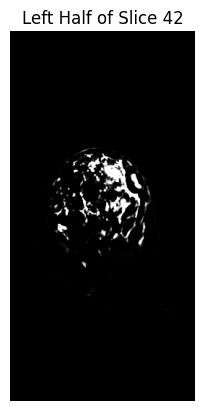

Left half:
 [[[3.8671e-04 4.1199e-04 5.5981e-04 ... 8.2684e-04 6.7568e-04 6.4039e-04]
  [3.9577e-04 5.0926e-04 6.6042e-04 ... 8.4305e-04 8.2350e-04 6.4087e-04]
  [6.6376e-04 8.5497e-04 8.5926e-04 ... 1.3103e-03 1.0481e-03 8.8739e-04]
  ...
  [1.1482e-03 9.5844e-04 1.0786e-03 ... 1.6499e-03 1.6594e-03 1.6766e-03]
  [1.1320e-03 9.3651e-04 1.0490e-03 ... 1.6422e-03 1.6708e-03 1.6775e-03]
  [1.0996e-03 8.8930e-04 1.0042e-03 ... 1.6413e-03 1.6651e-03 1.6804e-03]]

 [[3.8433e-04 3.4356e-04 6.6471e-04 ... 1.0185e-03 8.9025e-04 6.1131e-04]
  [4.5967e-04 3.6526e-04 6.4325e-04 ... 7.5674e-04 7.0190e-04 4.2462e-04]
  [7.7152e-04 6.8760e-04 8.4305e-04 ... 8.7070e-04 7.7486e-04 6.7806e-04]
  ...
  [1.5011e-03 5.8985e-04 5.1022e-04 ... 3.7050e-04 4.3392e-04 8.7357e-04]
  [1.4734e-03 5.7602e-04 5.0259e-04 ... 3.7003e-04 4.3607e-04 8.7547e-04]
  [1.4343e-03 5.5218e-04 4.9686e-04 ... 3.6955e-04 4.4012e-04 8.7452e-04]]

 [[3.2139e-04 2.7728e-04 6.5804e-04 ... 7.9393e-04 6.6948e-04 5.2452e-04]
  [4.5609e

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fgt_data_pre = np.load('./fgt_pre/output.npy')
print("Shape of FGT data:", fgt_data_pre.shape)

slice_fgt = fgt_data_pre[2, :, :, :]
print("Shape of slice 42:", slice_fgt.shape)

plt.imshow(slice_fgt[:,:,42], cmap='gray')
plt.title('FGT and Blood Vessel Segmentation pre contrast')
plt.axis('off')
plt.show()

mid_index = slice_fgt.shape[1] // 2

left_half = slice_fgt[:, :mid_index, :]

plt.imshow(left_half[:,:,42], cmap='gray')
plt.title('Left Half of Slice 42')
plt.axis('off')
plt.show()

print("Left half:\n", left_half)

np.save('./half_breast/left_half_pre.npy', left_half)



In [22]:
fgt_half_pre = np.load('./half_breast/left_half_post.npy')
print("Shape of slice 42:", fgt_half_pre.shape)

Shape of slice 42: (512, 256, 106)


Pre and post contrast side by side

(-0.5, 255.5, 511.5, -0.5)

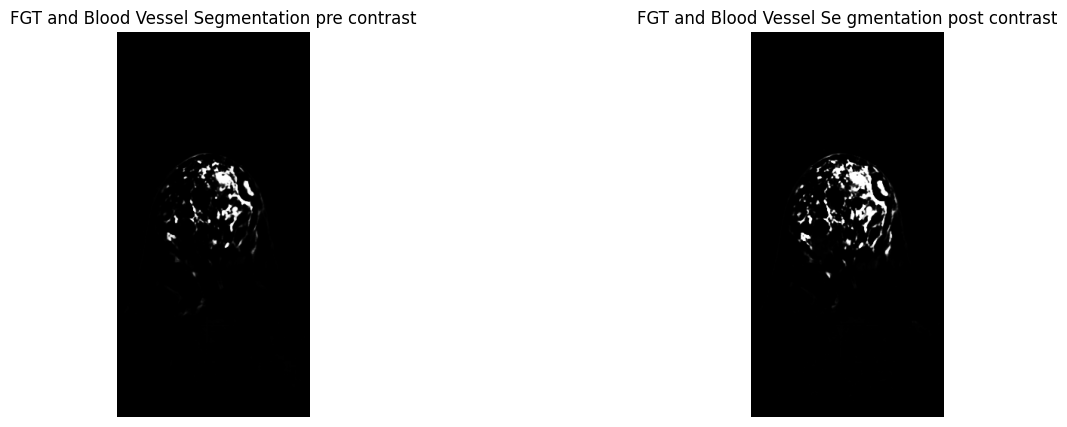

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fgt_half_pre = np.load('./half_breast/left_half_post.npy')
fgt_half_post = np.load('./half_breast/left_half_pre.npy')

#plotting the data
axes[0].imshow(fgt_half_pre[:, :, 42], cmap = 'gray')
axes[0].set_title('FGT and Blood Vessel Segmentation pre contrast')
axes[0].axis('off')

axes[1].imshow(fgt_half_post[:, :, 42], cmap = 'gray')
axes[1].set_title('FGT and Blood Vessel Se gmentation post contrast')
axes[1].axis('off')

#fgt defined by post contrast
#   count voxels in post contrast
#   percent enhancement of post contrast voxels
#   average = percent enhancement of those voxels
